In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 500
beta = torch.linspace(200e-4, 50e-4, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0018, device='cuda:0')

In [3]:
alpha_

tensor([0.9800, 0.9604, 0.9413, 0.9225, 0.9042, 0.8863, 0.8687, 0.8515, 0.8347,
        0.8182, 0.8021, 0.7863, 0.7709, 0.7557, 0.7410, 0.7265, 0.7123, 0.6984,
        0.6848, 0.6715, 0.6585, 0.6457, 0.6332, 0.6210, 0.6090, 0.5973, 0.5858,
        0.5746, 0.5636, 0.5528, 0.5423, 0.5319, 0.5218, 0.5119, 0.5022, 0.4926,
        0.4833, 0.4742, 0.4652, 0.4565, 0.4479, 0.4395, 0.4313, 0.4232, 0.4153,
        0.4075, 0.4000, 0.3925, 0.3852, 0.3781, 0.3711, 0.3643, 0.3575, 0.3510,
        0.3445, 0.3382, 0.3320, 0.3259, 0.3200, 0.3141, 0.3084, 0.3028, 0.2973,
        0.2919, 0.2867, 0.2815, 0.2764, 0.2715, 0.2666, 0.2618, 0.2571, 0.2525,
        0.2480, 0.2436, 0.2393, 0.2350, 0.2309, 0.2268, 0.2228, 0.2189, 0.2150,
        0.2112, 0.2075, 0.2039, 0.2003, 0.1968, 0.1934, 0.1900, 0.1867, 0.1835,
        0.1803, 0.1772, 0.1742, 0.1712, 0.1682, 0.1653, 0.1625, 0.1597, 0.1570,
        0.1543, 0.1517, 0.1491, 0.1466, 0.1441, 0.1417, 0.1393, 0.1370, 0.1347,
        0.1324, 0.1302, 0.1280, 0.1259, 

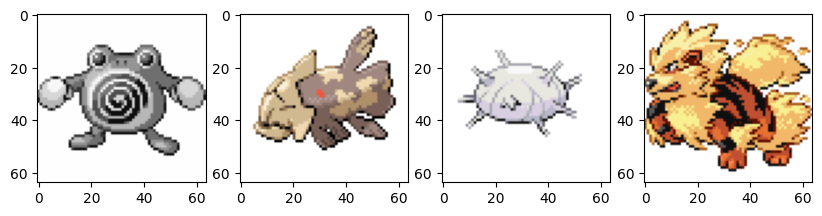

In [4]:
transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [6]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 64, 64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

  0%|          | 0/20001 [00:00<?, ?it/s]

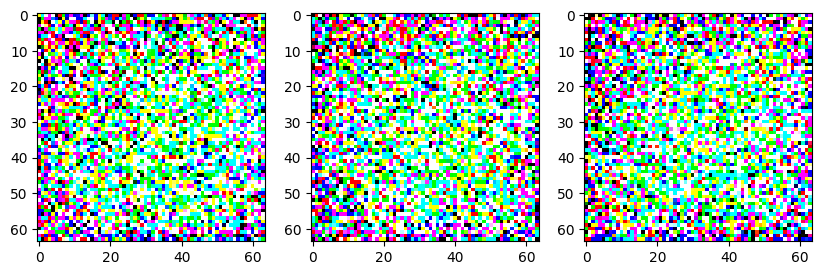

0.04444451:   2%|▏         | 499/20001 [00:43<24:42, 13.16it/s] 

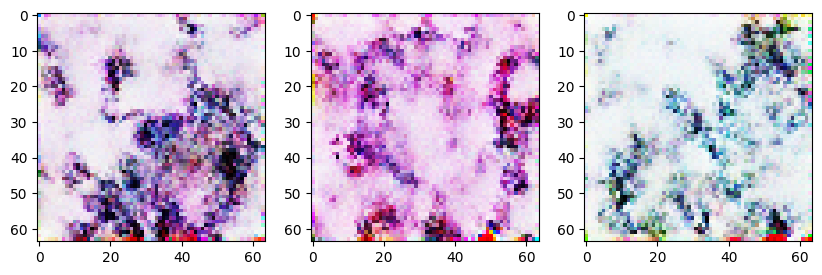

0.02170014:   5%|▍         | 999/20001 [01:27<24:08, 13.12it/s]  

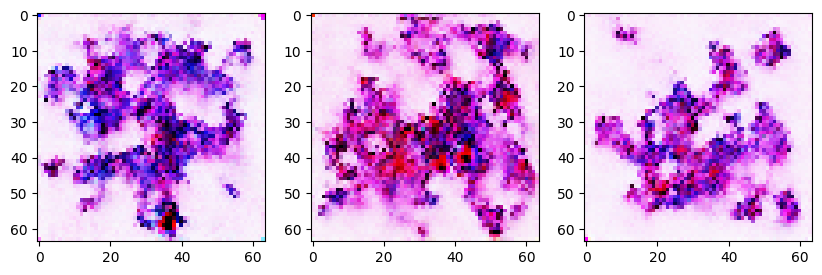

0.03510987:   7%|▋         | 1499/20001 [02:11<23:30, 13.11it/s]  

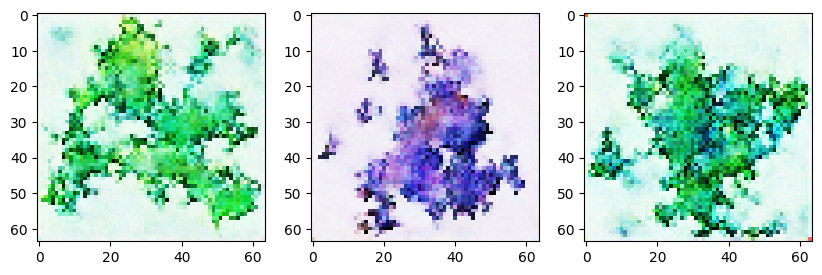

0.01774305:  10%|▉         | 1999/20001 [02:54<22:51, 13.13it/s]  

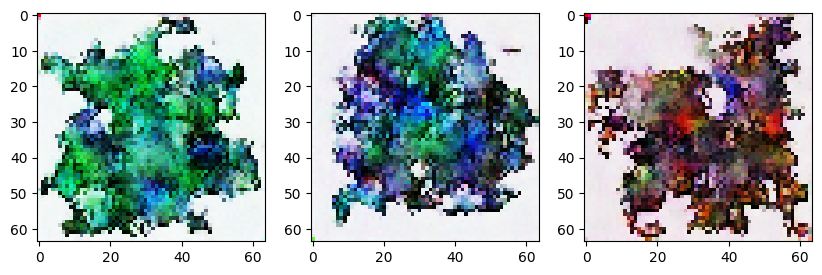

0.04155133:  12%|█▏        | 2499/20001 [03:38<22:09, 13.16it/s]  

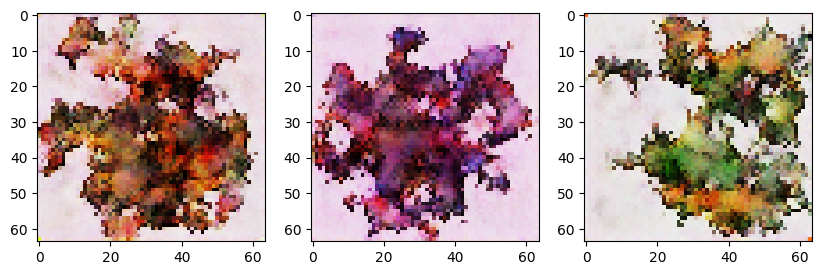

0.02129557:  15%|█▍        | 2999/20001 [04:22<21:30, 13.18it/s]  

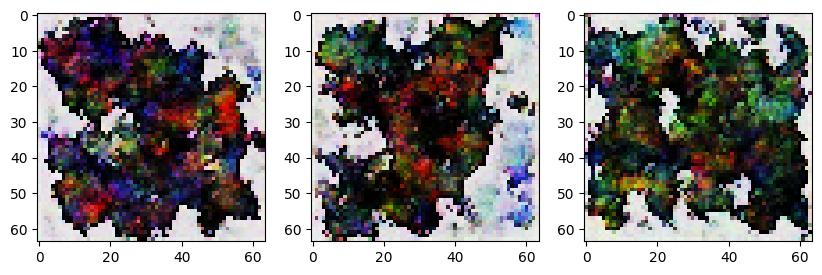

0.02931219:  17%|█▋        | 3499/20001 [05:05<20:53, 13.16it/s]  

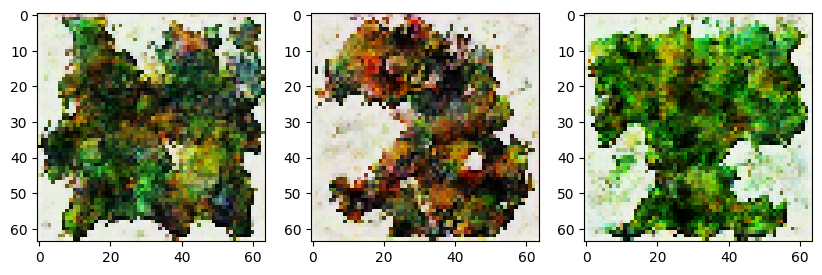

0.02905018:  20%|█▉        | 3999/20001 [05:49<20:16, 13.16it/s]  

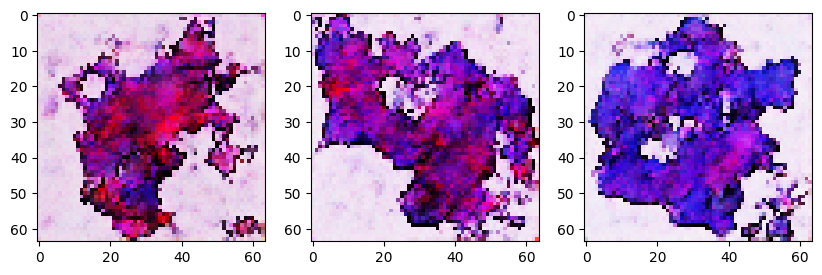

0.04268786:  22%|██▏       | 4499/20001 [06:32<19:36, 13.18it/s]  

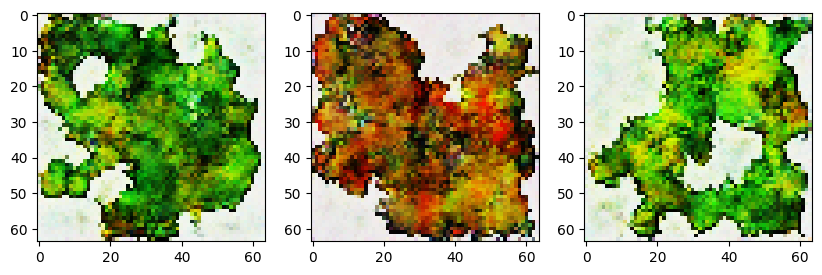

0.02241316:  25%|██▍       | 4999/20001 [07:16<19:00, 13.15it/s]  

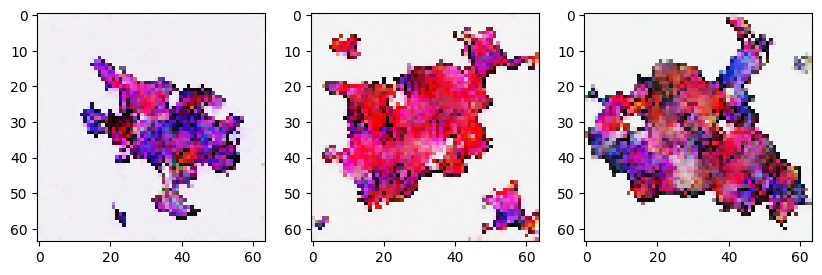

0.03259883:  27%|██▋       | 5499/20001 [08:00<18:21, 13.16it/s]  

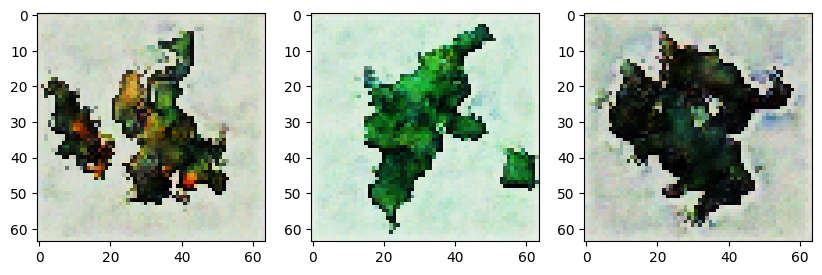

0.01412576:  30%|██▉       | 5999/20001 [08:43<17:44, 13.16it/s]  

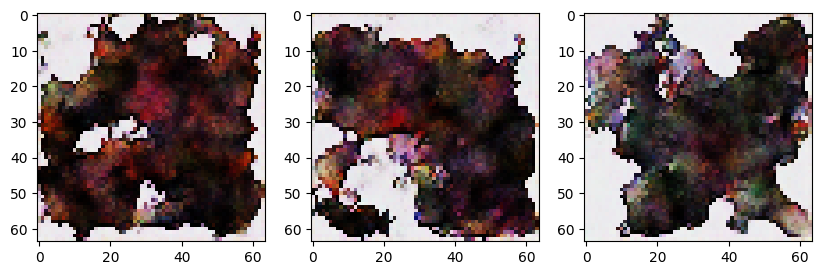

0.02221109:  32%|███▏      | 6499/20001 [09:27<17:07, 13.15it/s]  

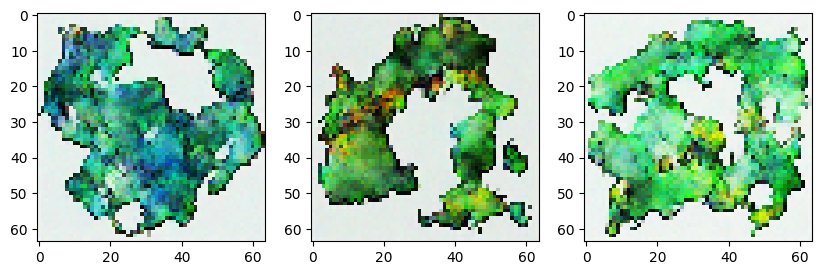

0.00978749:  35%|███▍      | 6999/20001 [10:10<16:27, 13.16it/s]  

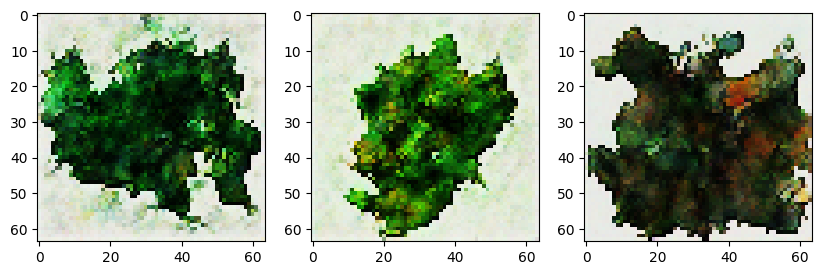

0.02657140:  37%|███▋      | 7499/20001 [10:54<15:50, 13.15it/s]  

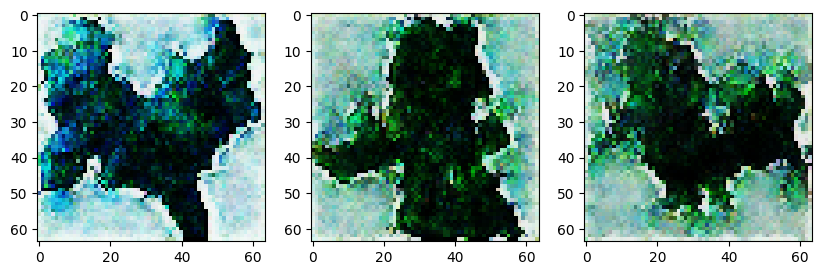

0.02677054:  40%|███▉      | 7999/20001 [11:37<15:12, 13.16it/s]  

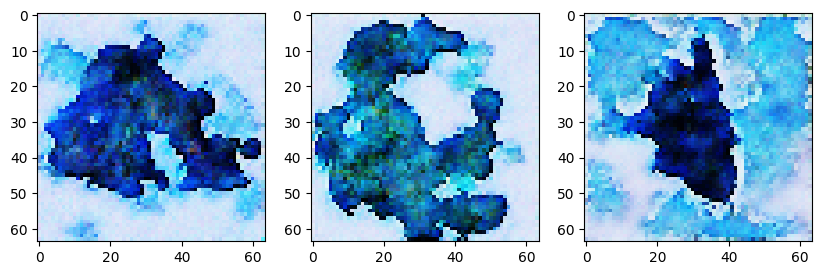

0.02314022:  42%|████▏     | 8499/20001 [12:21<14:34, 13.15it/s]  

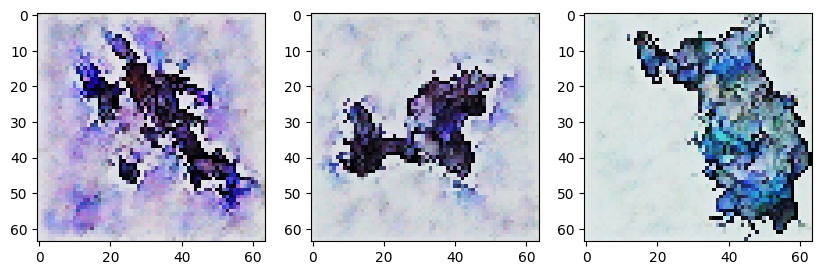

0.02756555:  45%|████▍     | 8999/20001 [13:05<13:55, 13.17it/s]  

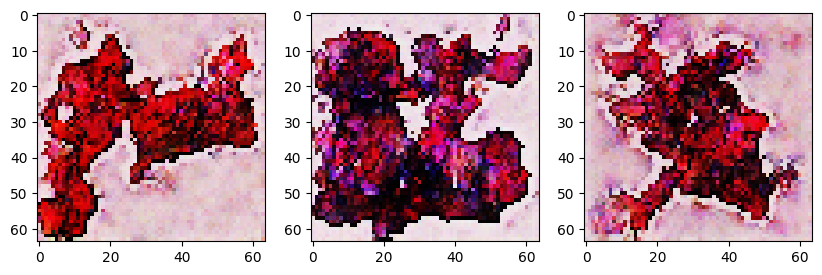

0.06017321:  47%|████▋     | 9499/20001 [13:48<13:18, 13.16it/s]  

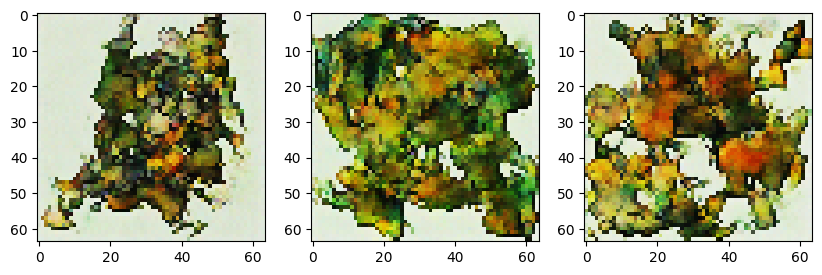

0.03658789:  50%|████▉     | 9999/20001 [14:32<12:41, 13.14it/s]  

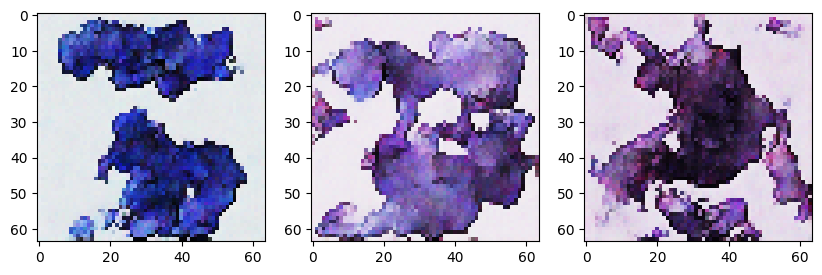

0.02210940:  52%|█████▏    | 10499/20001 [15:15<12:01, 13.17it/s]  

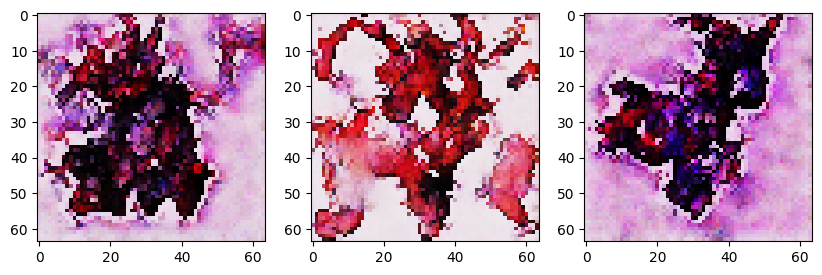

0.01645382:  55%|█████▍    | 10999/20001 [15:59<11:24, 13.15it/s]  

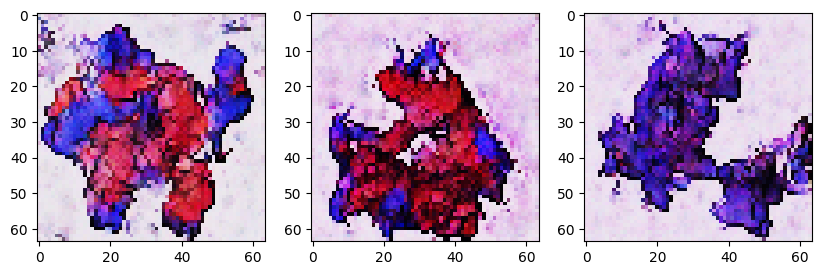

0.02690930:  57%|█████▋    | 11499/20001 [16:43<10:47, 13.13it/s]  

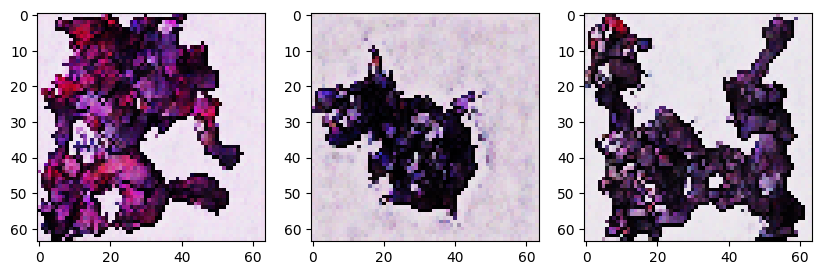

0.03161763:  60%|█████▉    | 11999/20001 [17:26<10:08, 13.14it/s]  

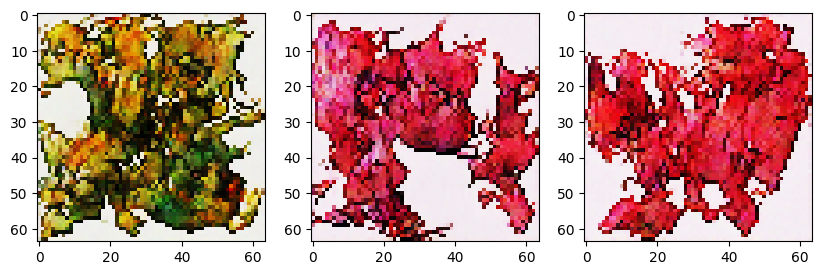

0.02312943:  62%|██████▏   | 12499/20001 [18:10<09:29, 13.16it/s]  

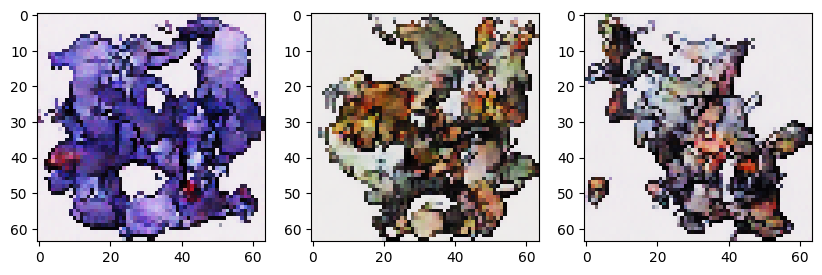

0.05284376:  65%|██████▍   | 12999/20001 [18:53<08:51, 13.16it/s]  

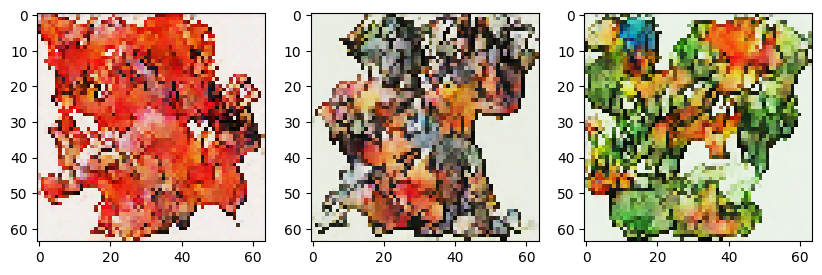

0.02967384:  67%|██████▋   | 13499/20001 [19:37<08:14, 13.15it/s]  

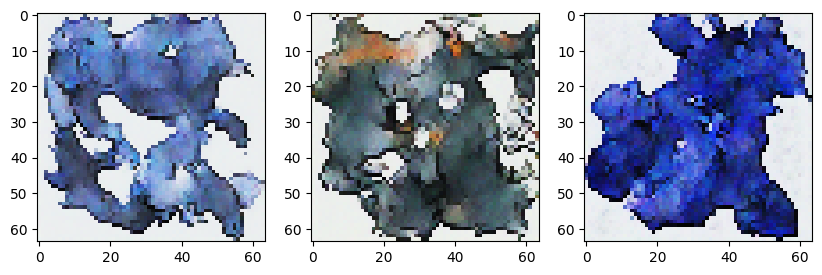

0.02888539:  70%|██████▉   | 13999/20001 [20:21<07:35, 13.16it/s]  

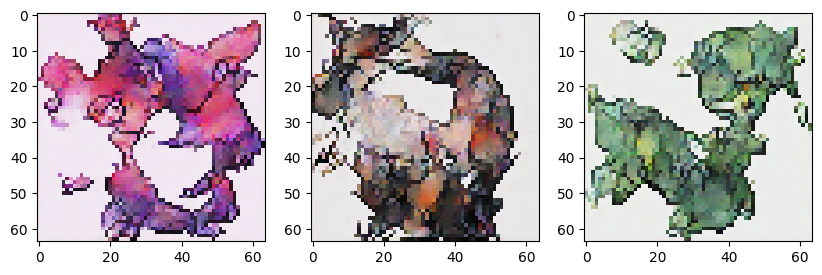

0.02869408:  72%|███████▏  | 14499/20001 [21:04<06:58, 13.16it/s]  

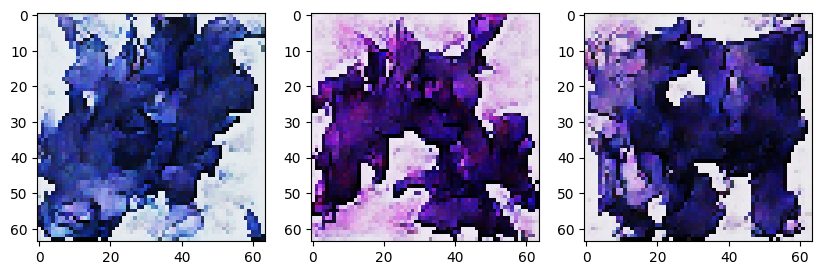

0.01825207:  75%|███████▍  | 14999/20001 [21:48<06:19, 13.18it/s]  

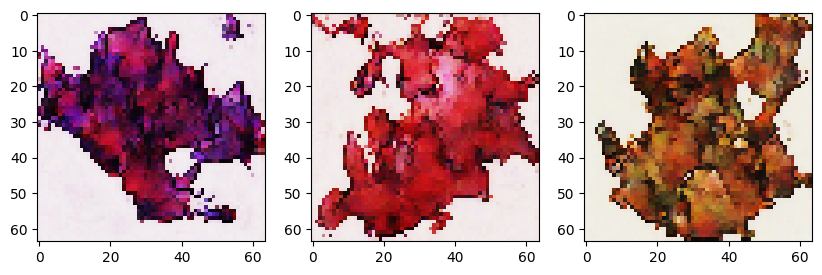

0.02509821:  77%|███████▋  | 15499/20001 [22:32<05:42, 13.14it/s]  

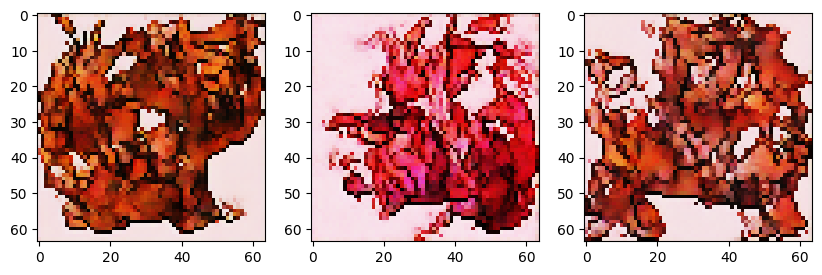

0.03260616:  80%|███████▉  | 15999/20001 [23:15<05:04, 13.16it/s]  

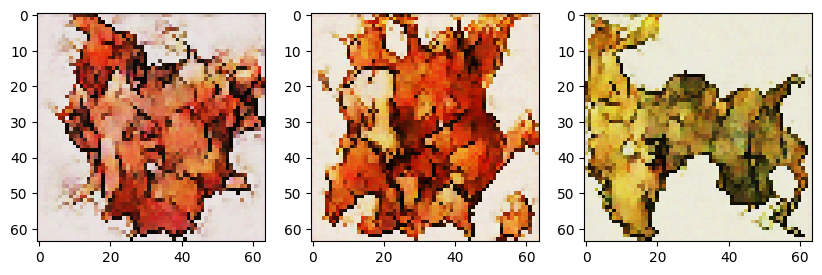

0.02427230:  82%|████████▏ | 16499/20001 [23:59<04:26, 13.16it/s]  

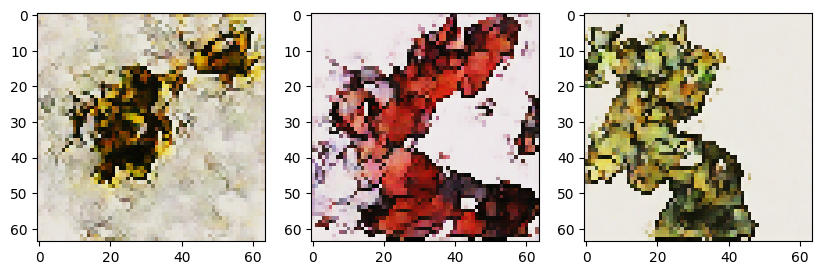

0.02088051:  85%|████████▍ | 16999/20001 [24:42<03:48, 13.16it/s]

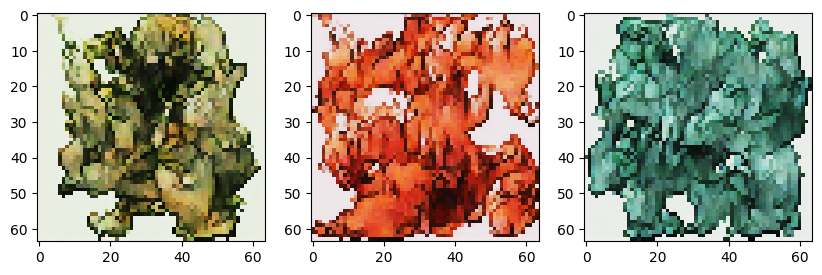

0.01729405:  87%|████████▋ | 17499/20001 [25:26<03:10, 13.16it/s]

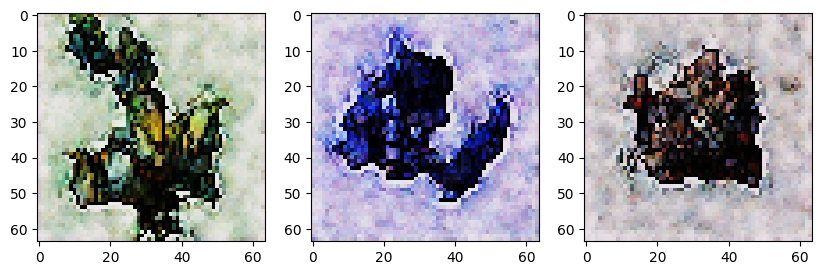

0.02467409:  90%|████████▉ | 17999/20001 [26:10<02:32, 13.15it/s]

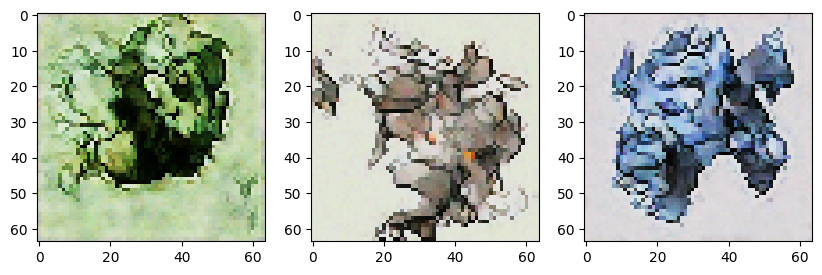

0.03570029:  92%|█████████▏| 18499/20001 [26:53<01:54, 13.16it/s]

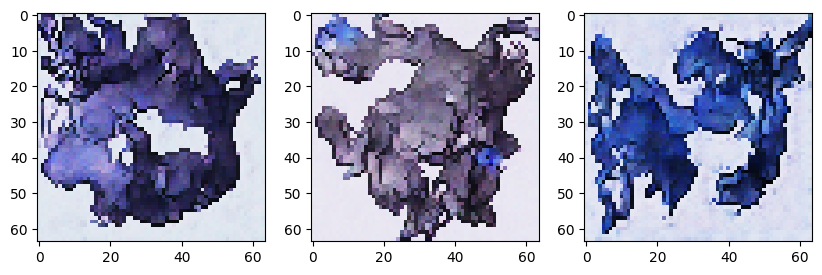

0.03767285:  95%|█████████▍| 18999/20001 [27:37<01:16, 13.17it/s]

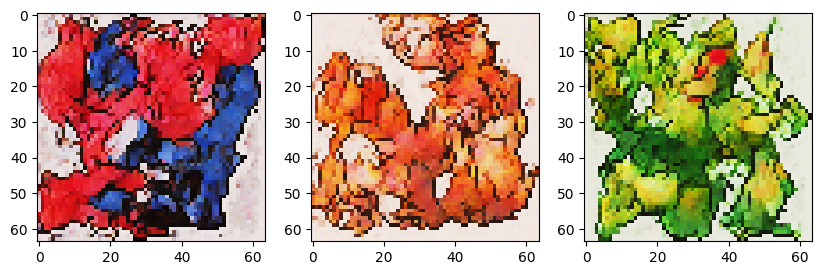

0.01941912:  97%|█████████▋| 19499/20001 [28:20<00:38, 13.18it/s]

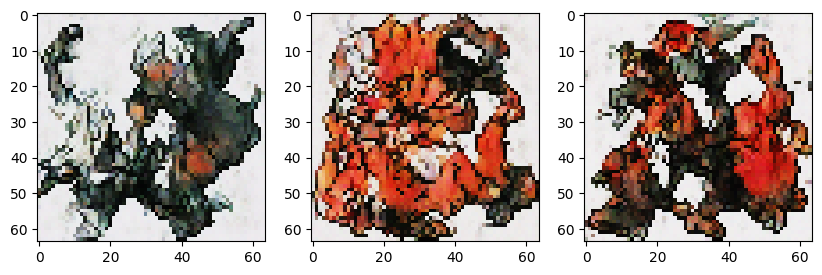

0.03236328: 100%|█████████▉| 19999/20001 [29:04<00:00, 13.16it/s]

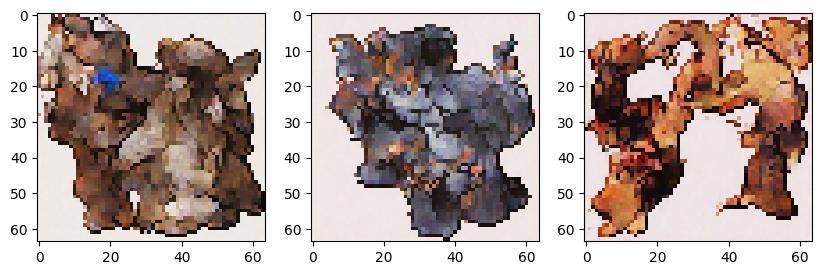

0.02023666: 100%|██████████| 20001/20001 [29:10<00:00, 11.43it/s]


In [7]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(20001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)
    
    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 500 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')